------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. In here functions are declared and described. If you want to see them applied and the results, please go to:

 ### __[Results](https://github.com/serbanradulescu/master_thesis/blob/main/project.ipynb)__ |  Code 
------------------------------------------------------------------------------------------------------------------------

In [8]:
import re
import wget
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from requests_html import HTMLSession
from itertools import combinations
from functools import lru_cache
from typing import List, Tuple
from zipfile import ZipFile
from os.path import exists
from time import sleep

In [9]:
class Parameter:
    def __init__(self, name):
        self.name = name
moisture = Parameter("moisture")
#print(moisture.name)

class Parameters:
    moisture = "moisture"
#print(Parameters.moisture)

In [10]:
@lru_cache #caching the return of the function for time optimisation; not sure if this function is supported in jupyter notebook
def get_links(parameters:tuple[str], time:List[str] = ["1_minute","5_minutes","10_minutes","hourly"]) -> dict:
    """Return the links from dwd corresponding to the parameters and timeframe we are interested

    Args:
        parameters (tuple[str]): a tuple with the parameters
        time (List[str], optional): the timeframe. Defaults to ["1_minute","5_minutes","10_minutes","hourly"].

    Returns:
        dict: a dictionary containing the links
    """
    dwd_links = {interval:{key: None for key in parameters} for interval in time}
    for interval in time:
        for parameter in parameters:
            url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/' + str(interval) + '/' + parameter + '/historical/'
            try:
                session = HTMLSession()
                response = session.get(url)
                dwd_links[interval][parameter] = response.html.absolute_links

            except requests.exceptions.RequestException as e:
                print(e)
    return dwd_links

In [11]:
def get_date(link:str) -> Tuple[int,int]:
    """Returns the years from when the data is available.

    Args:
        link (str): the link that has included the dails for the available data time

    Returns:
        Tuple[int,int]: start time, end time
    """
    m = re.findall('\d{8}', link)
    if m:
        return (int(m[0][:4]),int(m[1][:4]))
    return (0,0)

In [12]:
def count_datapoints(dwd_links:dict,time,parameter:str, start_year:int, end_year:int) -> int:
    """Counting the datapoints for a certain parameter

    Args:
        dwd_links (dict): source of data (dwd)
        time (_type_): time period (10_minutes, hourly)
        parameter (str): climatic parameters we are interested in
        start_year (int): start of the observation period
        end_year (int): end of the observation period

    Returns:
        int: numbers of datapoints of the parameter that contain the complete period we are interested
    """
    i=0
    for link in dwd_links[time][parameter]:
        try:
            start_interval = int(get_date(link)[0])
            end_interval = int(get_date(link)[1])
            if ((start_interval <= start_year)  & (end_interval >= end_year)):
                i = i+1
        except:
            pass
    return i

In [13]:
def show_available_data(dwd_links:dict,time, parameters: List[str]):
    data_balance = pd.DataFrame(columns = parameters, index = [str(i) + "'s - present" for i in range(1950,2020,10)])
    for parameter in parameters:
        for i in range(1950,2020,10):
            data_balance[parameter][str(i)+ "'s - present"] = count_datapoints(dwd_links,time,parameter, i, 2020)
    display(data_balance)

In [14]:
def ids_datapoints(dwd_links:dict,time:str,parameter:str, start_year:int, end_year:int) -> List[str]:
    """Returns the ids of the weather station that has entries for the parameter in the mentioned timeframe

    Args:
        dwd_links (dict): source of data (dwd)
        time (str): time period (10_minutes, hourly)
        parameter (str): climatic parameters we are interested in
        start_year (int): start of the observation period
        end_year (int): end of the observation period

    Returns:
        List[str]: ids of weather stations that have the parameter that contain the complete period we are interested
    """
    list = []
    for link in dwd_links[time][parameter]:
        try:
            start_interval = int(get_date(link)[0])
            end_interval = int(get_date(link)[1])
            if ((start_interval <= start_year)  & (end_interval >= end_year)):
                id = re.findall("_\d{5}_",str(link))[0]
                ##print("link")
                list.append(id[1:-1])
        except:
            pass
    return list

parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters)

In [15]:
"""def common_stations(paramer1:str, parameter2:str, time:str, interval: List[int]):
    print(common_stations)
    print(f"{paramer1} and {parameter2} have the following number of stations that measured in:")
    full_list = []
    for i in interval:
        list1 = ids_datapoints(dwd_links,time,paramer1,i,2020)
        list2 = ids_datapoints(dwd_links,time,parameter2,i,2020)
        list1_as_set = set(list1)
        intersection = list1_as_set.intersection(list2)
        intersection_as_list = List(intersection)
        full_list = full_list + intersection_as_list
        print(str(i) + " - present" + ": " + str(len(intersection_as_list)))        
    return full_list
def complex_common_stations(parameters:List[str],time:str, interval: List[int]):
    ids =[{i:{parameter:ids_datapoints(dwd_links,time,parameter,i,2020)}} for parameter in parameters for i in interval]
    for i in range(0,len(interval)):
        print(ids[i])
    for i in range(2, len(parameters)+1):
        combined = combinations(parameters, i)
        #print(" ".join(str(e) for e in combined) )
        #for j in combined:
            #print(ids)
        #print(set.intersection(*[set(list) for list in p]))       

#complex_common_stations(["moisture", "dew_point", "air_temperature"],"hourly", range(1950,2020,10))
"""
def simple_common_stations(ids_parameter1: List[int],ids_parameter2: List[int]) -> List:
    """Common stations between two parameters

    Args:
        ids_parameter1 (List[int]): ids of the first parameter
        ids_parameter2 (List[int]): ids of the second parameter

    Returns:
        List: a list with the common ids of the parameters
    """
    list1_as_set = set(ids_parameter1)
    intersection = list1_as_set.intersection(ids_parameter2)
    intersection_as_list = list(intersection)
    return intersection_as_list


In [16]:
def create_df(parameter:str,time:str,start_year:int,end_year:int, is_test = True):

    test_count = 0
    if(is_test):
        limit =4
    else:
        limit = 99999
    df = pd.DataFrame()
    for link in dwd_links[time][parameter]:   
        if (test_count <= limit):
            test_count+=1
            filename = str.split(link,"/")[-1]
            
            if(not exists("downloads/" + time + "/" + parameter + "/" + filename)):
                file_zip = wget.download(link,"downloads/"+time+"/" + parameter + "/")
                print("downloading" + filename + "...",end = " ", flush=True)
            else:
                file_zip = "downloads/"+ time+ "/" + parameter + "/" + filename
                print("FOUND "+ filename, end =" ", flush=True)
                sleep(1)
            try:    
                with ZipFile(file_zip) as myzip:
                    for filename in myzip.namelist():
                        if "Metadat" not in filename:
                            with myzip.open(filename) as myfile:
                                this_df = pd.read_csv(myfile, sep =";")
                                
                                df = pd.concat([df,this_df])
            except:
                print("Not able to open:",filename, "Reason: unknown.")
    return df



In [17]:
def coordinates_stations(ids:List[str], path_info:str ):
    df = pd.read_csv(path_info, header=None, names=["raw"], sep = ";", encoding = "latin1", skiprows=2)
    #df["id"] = df["raw"].apply(lambda x: x[0:5])
    df["id"] = df["raw"].str.extract(r'(\d{5})')
    #df["period"] = df["raw"].str.findall(r'(\d{8})')
    #df["height"] = df["raw"].str.extract(r'(\s+\d{1,3}\s+)')
    df["coord"] = df["raw"].str.findall(r'(\d{1,2}\.{1}\d{4})')
    df[['lat','lon']] = pd.DataFrame(df.coord.tolist(), index= df.index)
    df["lat"]=df["lat"].apply(lambda x: float(x))
    df["lon"]=df["lon"].apply(lambda x: float(x))
    processed_df = df[["id","lat","lon"]]
    if ids == None:
        return processed_df
    else:
        return processed_df[processed_df["id"].isin(ids)]

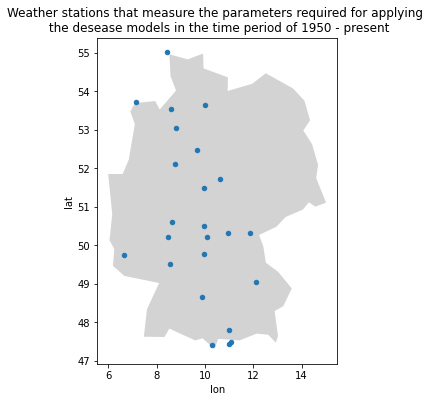

In [22]:
def plot_points_germany(start_year:int, end_year:int = 2020):
    moisture_year_h = ids_datapoints(dwd_links,"hourly","moisture",start_year,2020)
    dew_point_year_h = ids_datapoints(dwd_links,"hourly","dew_point",start_year,2020)
    air_temp_year_h = ids_datapoints(dwd_links,"hourly","air_temperature",start_year,2020)

    common_ids = (simple_common_stations(simple_common_stations(moisture_year_h,dew_point_year_h),air_temp_year_h))
    stations_coordinates = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")

    fig, ax = plt.subplots(figsize=(8,6))
    countries = gpd.read_file( gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey",ax=ax)
    stations_coordinates.plot(x="lon", y="lat", kind="scatter",title=f"Weather stations that measure the parameters required for applying \n the desease models in the time period of {start_year} - present",  ax=ax)

    plt.show()
plot_points_germany(1950)

### The following code is written just to email me when the files are downloaded/models are trained

In [19]:
import smtplib, ssl, os

def mail_me():
    port = 465  # For SSL
    smtp_server = "smtp.gmail.com"
    sender_email = "computersays521@gmail.com"  # Enter your address
    receiver_email = "radulescu_serban_petre@yahoo.com"  # Enter receiver address
    password = open("mailingfile.txt","r").readlines()[0]
    message = """\
    Subject: Hi there

    It seems that what you were working on is done. Or you had some errors. Either way the program is completed. """

    context = ssl.create_default_context()
    with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)